# NASA - Nearest Earth Objects 
## Random Forest classier for cumulative data for Nearest Earth Objects by NASA
https://www.kaggle.com/datasets/sameepvani/nasa-nearest-earth-objects



In [5]:
from sklearn import ensemble
from sklearn import model_selection as mls
from sklearn import metrics
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np


In [6]:
from google.colab import files
uploaded = files.upload()

Saving archive.zip to archive.zip


In [46]:
from zipfile import ZipFile
zip_file = ZipFile('archive.zip')
df = pd.read_csv(zip_file.open('neo_v2.csv'))

In [47]:
df = df.drop(["name", "orbiting_body", "sentry_object", "id"],axis=1)
# df.set_index("id", inplace=True)
df["hazardous"] = [int(obs) for obs in df["hazardous"]]
df["est_diameter"] = (df["est_diameter_min"]+df["est_diameter_max"])/2
df.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous,est_diameter
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,0,1.938843
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,1,0.430073
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,0,1.168268
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,0,0.156150
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,1,0.412613


In [48]:
df.isnull().sum()

est_diameter_min      0
est_diameter_max      0
relative_velocity     0
miss_distance         0
absolute_magnitude    0
hazardous             0
est_diameter          0
dtype: int64

In [49]:
df.hazardous.value_counts()

0    81996
1     8840
Name: hazardous, dtype: int64

In [50]:
X = df.drop(["hazardous", "est_diameter_min",	"est_diameter_max"], axis=1)
y = df.hazardous

In [51]:
df.describe()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous,est_diameter
count,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000,90836.000000,90836.000000
mean,0.127432,0.284947,48066.918918,3.706655e+07,23.527103,0.097318,0.206189
std,0.298511,0.667491,25293.296961,2.235204e+07,2.894086,0.296392,0.483001
min,0.000609,0.001362,203.346433,6.745533e+03,9.230000,0.000000,0.000985
25%,0.019256,0.043057,28619.020645,1.721082e+07,21.340000,0.000000,0.031156
50%,0.048368,0.108153,44190.117890,3.784658e+07,23.700000,0.000000,0.078260
75%,0.143402,0.320656,62923.604633,5.654900e+07,25.700000,0.000000,0.232029
max,37.892650,84.730541,236990.128088,7.479865e+07,33.200000,1.000000,61.311595


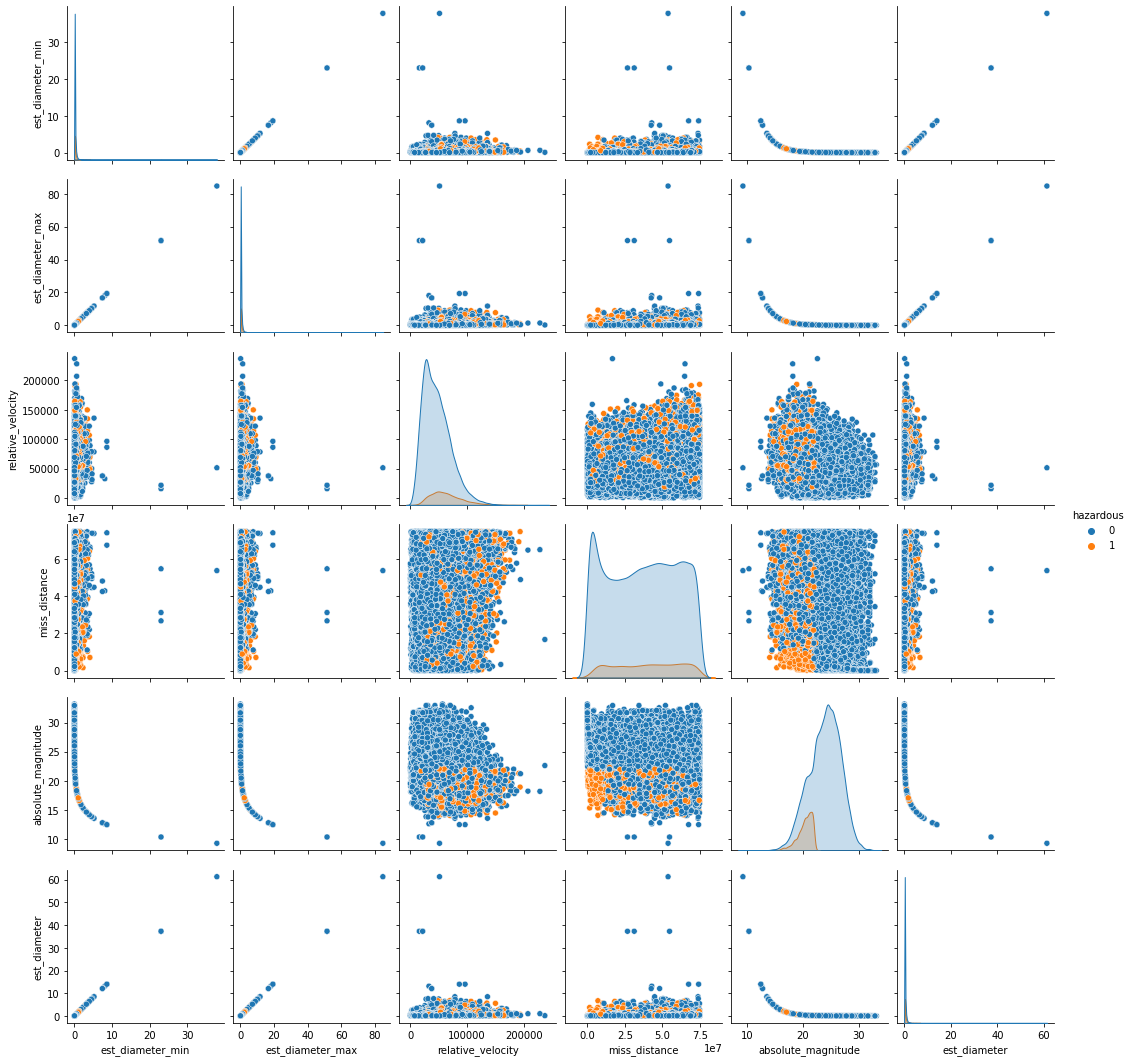

In [53]:
sns.pairplot(df, hue= "hazardous")

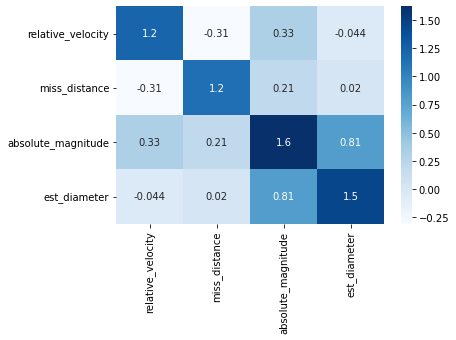

In [13]:
ivcorr = np.linalg.inv(X.corr())
ivcorr = pd.DataFrame(ivcorr, index=X.columns, columns= X.columns)
sns.heatmap(ivcorr, cmap= "Blues", annot=True)

In [54]:
X_train, X_test, y_train, y_test = mls.train_test_split(X, y, test_size= 0.33, random_state= 5)

In [55]:
random_forest_bench = ensemble.RandomForestClassifier(criterion= "entropy",
                                                n_estimators= 60,
                                                max_depth= 6,
                                                min_samples_split= 300,
                                                min_samples_leaf= 150,
                                                bootstrap= True, n_jobs=-1, random_state= 15)

random_forest_bench.fit(X_train, y_train)


pred_bench = random_forest_bench.predict(X_test)
pd.Series(pred_bench).value_counts()

0    29442
1      534
dtype: int64

In [56]:
random_forest_bench.score(X_test, y_test), metrics.f1_score(y_test,pred_bench), metrics.precision_score(y_test, pred_bench) ,metrics.recall_score(y_test, pred_bench)

(0.911929543634908,
 0.2418150488225158,
 0.7883895131086143,
 0.14280868385345996)

In [59]:

importance_df_bench = pd.DataFrame({"feature": list(X_train),
                              "importance_score": random_forest_bench.feature_importances_})

importance_df_bench.sort_values("importance_score", ascending=False)

,feature,importance_score
2,absolute_magnitude,0.494394
3,est_diameter,0.383227
1,miss_distance,0.079488
0,relative_velocity,0.042890


In [60]:
clf_rf = ensemble.RandomForestClassifier(bootstrap= True, random_state= 5)
params = {"criterion": ["entropy"],
          "n_estimators": range(50,101,10),
          "max_depth": range(2,13,2),
          "min_samples_split": range(300, 1501, 300),
          "min_samples_leaf": range(150,751, 150)}

In [61]:
grid_clf = mls.RandomizedSearchCV(clf_rf, params, cv=5, scoring="f1")


In [62]:
grid_clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=5),
                   param_distributions={'criterion': ['entropy'],
                                        'max_depth': range(2, 13, 2),
                                        'min_samples_leaf': range(150, 751, 150),
                                        'min_samples_split': range(300, 1501, 300),
                                        'n_estimators': range(50, 101, 10)},
                   scoring='f1')

In [63]:
grid_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 750,
 'min_samples_split': 1200,
 'n_estimators': 80}

In [64]:
best_clf = grid_clf.best_estimator_
y_pred = best_clf.predict(X_test)
best_clf.score(X_test, y_test), metrics.f1_score(y_test,y_pred), metrics.precision_score(y_test, y_pred) ,metrics.recall_score(y_test, y_pred)

(0.9113957832933013,
 0.25560538116591924,
 0.7354838709677419,
 0.1546811397557666)

In [65]:
importance_df = pd.DataFrame({"feature": list(X_train),
                              "importance_score": best_clf.feature_importances_})

importance_df.sort_values("importance_score", ascending=False)

,feature,importance_score
2,absolute_magnitude,0.507497
3,est_diameter,0.404628
1,miss_distance,0.056548
0,relative_velocity,0.031326
